# Notes:


This notebook updates Pipe_Analysis_Test.ipynb to analyses the results of the dDM/dz values created in Pipe_Creation_Plus_LSS.ipynb.

It analyses large scale structure content as well as DM

It continues using the method described in Zhang+20: https://arxiv.org/abs/2011.14494

# Imports:

In [1]:
import os

import numpy as np
import illustris_python as il

from frb.dm import igm
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import binned_statistic_dd

from astropy import units as u
from numpy import random as rand
from astropy import constants as c
from matplotlib import pyplot as plt
from astropy.cosmology import Planck15 as cosmosource


# Load Theory

In [2]:
#get theory for next plot
theory_z_2 = np.array([0.0001,0.1,0.2,0.3,0.4,0.5,0.7,1.0,1.5,2.0])
print('calculating average DMcosm')
cosm_theory_2=[igm.average_DM(i) for i in theory_z_2]
cosm_theory_2=[i.value for i in cosm_theory_2]
print('calculating average DMigm')
igm_theory_2=[igm.average_DMIGM(i) for i in theory_z_2]
igm_theory_2=[i.value for i in igm_theory_2]
print('calculating average DMhalo')
halo_theory_2=[igm.average_DMhalos(i) for i in theory_z_2]
halo_theory_2=[i.value for i in halo_theory_2]

calculating average DMcosm
calculating average DMigm
calculating average DMhalo


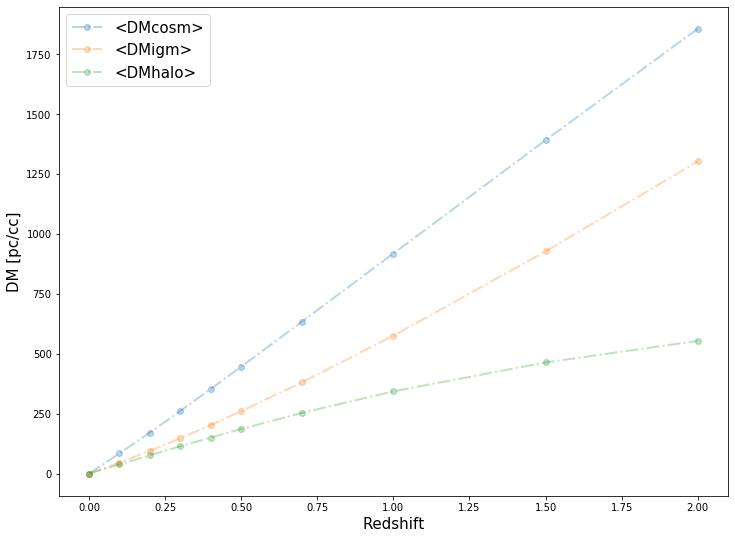

In [3]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

plt.legend(fontsize=15)
plt.show()


# Load pipe dDM/dz values

In [407]:
#############################
#Identify files to be loaded#
#############################
#simulation to load data for
sim_to_load = 'TNG300-3'


#all files
all_files = os.listdir('.')
#.npy files
npy_files = [i for i in all_files if '.npy' in i]
#ddmdz files
dDMdz_files = [i for i in npy_files if 'dDMdz_Output' in i]
#correct simulation
dDMdz_files = [i for i in npy_files if sim_to_load in i]
#sort
dDMdz_files.sort()
#reverse order
dDMdz_files = dDMdz_files[::-1]
print(dDMdz_files)

#list of snapshots wth data
snap_list = [int(i.split('_')[3]) for i in dDMdz_files]
print(snap_list)


['Sim_TNG300-3_Snap_99_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_91_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_84_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_78_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_72_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_67_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_59_dDMdz_Output.npy', 'Sim_TNG300-3_Snap_50_dDMdz_Output.npy']
[99, 91, 84, 78, 72, 67, 59, 50]


In [408]:
#######################################
#load the files into a data dictionary#
#######################################

#path to data
#basePath = '/ptmp/cwalker/Illustris_FRB_Project/TNG_copies/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)
basePath = '/virgo/simulations/IllustrisTNG/{0}/output/'.format(sim_to_load)

dDMdz_dict = {} #initialise dictionary to hold dDMdz values
halo_dict  = {} #initialise dictionary to hold number of halo cells
fila_dict  = {} #initialise dictionary to hold number of filament cells
void_dict  = {} #initialise dictionary to hold number of void cells

snap_redshifts = {} #initialise dictionary to hold redshifts of snapshots
snap_z_list = [] #initialise an array to hold these redshift values for plotting

for i in range(len(dDMdz_files)):#loop over files
    
    #load and extract dats
    snapshot = dDMdz_files[i].split('_')[3] #extract snapshot number
    vals = np.load(dDMdz_files[i],allow_pickle=True).tolist() #extract values from file
    dDMdz_dict[snapshot]=vals['dDMdz']*u.pc*u.cm**-3 #append dDMdz values to dictionary with snapshot number as key
    halo_dict[snapshot]=np.array(vals['nHalo']) #append number of halo cells to dictionary with snapshot number as key
    fila_dict[snapshot]=np.array(vals['nFilament']) #append number of filament cells to dictionary with snapshot number as key
    void_dict[snapshot]=np.array(vals['nVoid']) #append number of void cells to dictionary with snapshot number as key
    header = il.groupcat.loadHeader(basePath,int(snapshot)) #extract simulation and snapshot header
    snap_redshifts[snapshot]=header['Redshift'] #get redshift at this snapshot
    snap_z_list.append(header['Redshift']) #append to array


print(snap_redshifts['99'])    
print(dDMdz_dict['99'])
print(halo_dict['99'])
print(halo_dict['99']+fila_dict['99']+void_dict['99'])
print(len(snap_redshifts))

2.220446049250313e-16
[1568.90241171 1049.52115389  872.8401857  ...  797.12019055  986.98289162
  917.38023128] pc / cm3
[0 0 0 ... 0 0 0]
[10000 10000 10000 ... 10000 10000 10000]
8


In [409]:
print(np.mean([1,2,3,4,5,6]))
print(np.mean([np.mean([1,2,3]),np.mean([4,5,6])]))
print(len(dDMdz_dict['99']))

3.5
3.5
5125


# Calculate DM for a single line of sight, also extract LSS details

In [410]:
#calculate DMIGM(z) for a single line of sight according to paper
x = snap_list


DMIGM     = [[0]*u.pc*u.cm**-3] #set initial condition to DM(z=0)=0
HaloCells = [0.] #initialise arrays to store the number of halo cells for the created LoS
FilaCells = [0.] #initialise arrays to store the number of filament cells for the created LoS
VoidCells = [0.] #initialise arrays to store the number of void cells for the created LoS

for i in range(len(x)-1): #loop over snapshots
    
    print(i)
    #get snapshot number for this snapshot
    snap_id = str(snap_list[i])
    #get snapshot number for next snapshot
    snap_id_ = str(snap_list[i+1])
    print(snap_id,snap_id_)
    #get this snapshot redshift
    snap_z = snap_redshifts[snap_id]
    #get next snapshot redshift
    snap_z_ = snap_redshifts[snap_id_]
    print(snap_z,snap_z_)
    #randomly select dDM/dz and LSS cell values for this redshift
    rand_idx = np.random.choice(np.arange(len(dDMdz_dict[snap_id])))
    print(rand_idx)
    rand_dDMdz = dDMdz_dict[snap_id][rand_idx]
    rand_nHalo = halo_dict[snap_id][rand_idx]
    rand_nFila = fila_dict[snap_id][rand_idx]
    rand_nVoid = void_dict[snap_id][rand_idx]
    print(rand_dDMdz)
    #randomly select dDM/dz and LSS cell values for next redshift
    rand_idx_ = np.random.choice(np.arange(len(dDMdz_dict[snap_id_])))    
    rand_dDMdz_ = dDMdz_dict[snap_id_][rand_idx_]
    rand_nHalo_ = halo_dict[snap_id_][rand_idx_]
    rand_nFila_ = fila_dict[snap_id_][rand_idx_]
    rand_nVoid_ = void_dict[snap_id_][rand_idx_]
    print(rand_dDMdz,rand_dDMdz_)
    #create the DM value
    nextDM = DMIGM[i] + ((0.5*(rand_dDMdz+rand_dDMdz_)) * (snap_z_ -  snap_z))
    #create the number of LSS cell value by averaging those of the two chosen pipes
    nextHalo = (0.5*(rand_nHalo+rand_nHalo_))
    nextFila = (0.5*(rand_nFila+rand_nFila_))
    nextVoid = (0.5*(rand_nVoid+rand_nVoid_))
    DMIGM.append(nextDM)
    HaloCells.append(nextHalo)
    FilaCells.append(nextFila)
    VoidCells.append(nextVoid)

    
#create the fractions of LSS cells at each point
fraction_Halo = np.array(HaloCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))
fraction_Fila = np.array(FilaCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))
fraction_Void = np.array(VoidCells)/(np.array(HaloCells)+np.array(FilaCells)+np.array(VoidCells))

print(len(x),len(DMIGM))
print(HaloCells)
print(fraction_Halo)
print(fraction_Fila)
print(fraction_Void)
print(fraction_Halo+fraction_Fila+fraction_Void)

0
99 91
2.220446049250313e-16 0.09940180263022191
1769
906.7664470517128 pc / cm3
906.7664470517128 pc / cm3 1883.0961682016189 pc / cm3
1
91 84
0.09940180263022191 0.19728418237600986
3165
1678.3803043505127 pc / cm3
1678.3803043505127 pc / cm3 1174.7767073686848 pc / cm3
2
84 78
0.19728418237600986 0.2977176845174465
4310
1593.8103321579342 pc / cm3
1593.8103321579342 pc / cm3 963.3486926380107 pc / cm3
3
78 72
0.2977176845174465 0.3999269646135635
4301
1401.5394456619208 pc / cm3
1401.5394456619208 pc / cm3 1238.9484282482617 pc / cm3
4
72 67
0.3999269646135635 0.5030475232448832
627
1283.9978775934578 pc / cm3
1283.9978775934578 pc / cm3 1080.59775684909 pc / cm3
5
67 59
0.5030475232448832 0.7001063537185233
1219
1344.697807163679 pc / cm3
1344.697807163679 pc / cm3 1261.5385176468365 pc / cm3
6
59 50
0.7001063537185233 0.9972942257819404
4225
2147.6057039325483 pc / cm3
2147.6057039325483 pc / cm3 2875.3436032357404 pc / cm3
8 8
[0.0, 6.5, 0.0, 3.5, 0.0, 0.0, 1.0, 28.0]
[    nan 0

/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


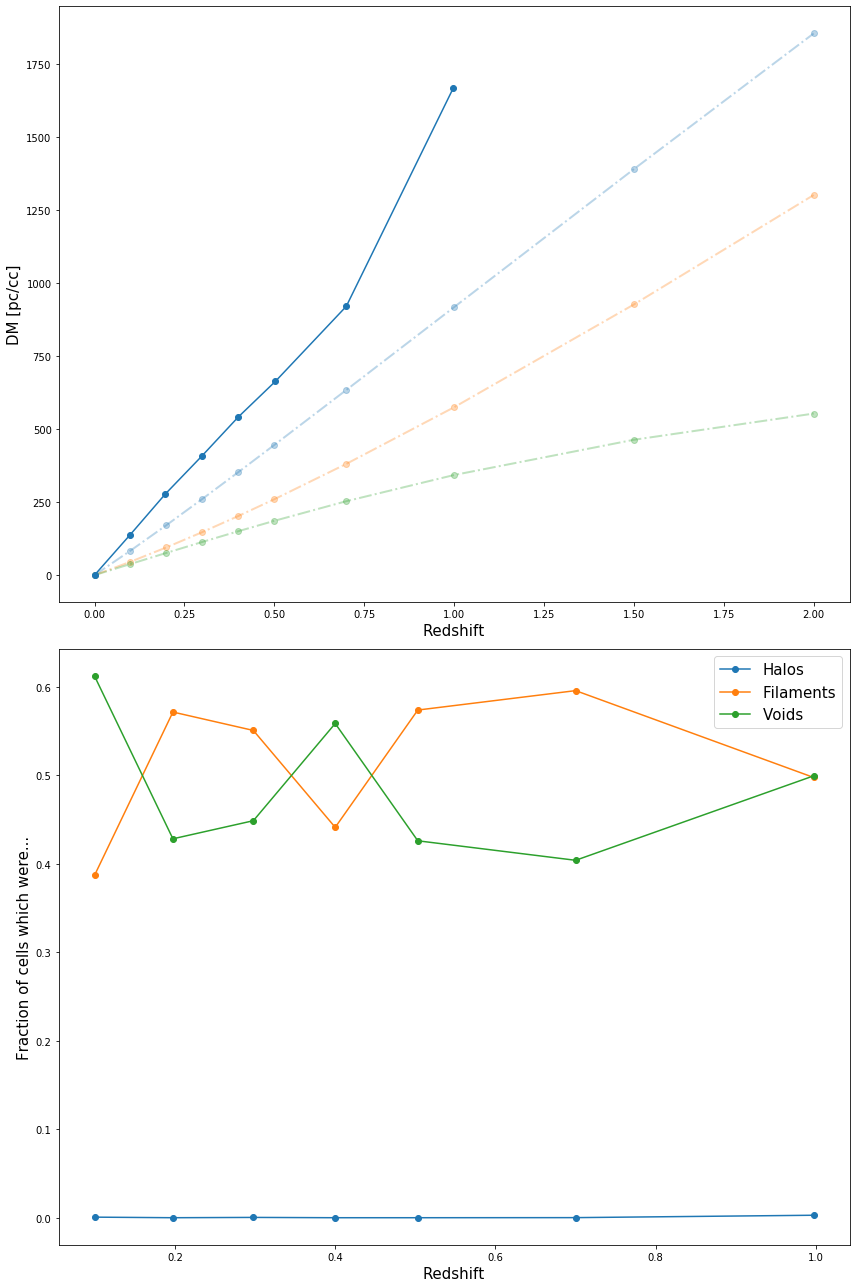

In [411]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,DMIGM,marker='o',label='Random pipe DM')

ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)

ax2.plot(snap_z_list,fraction_Halo,marker='o',label='Halos')
ax2.plot(snap_z_list,fraction_Fila,marker='o',label='Filaments')
ax2.plot(snap_z_list,fraction_Void,marker='o',label='Voids')

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Single_LoS_Analysis.png'.format(sim_to_load),format='png')
plt.show()


# Calculate DM for many lines of sight

## figuring out array version

In [412]:
print(snap_list)

nlos = 2 #number of lines of sight

################################################
#original version from Pipe_Analysis_Test.ipynb#
################################################

test_dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3
test_z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

print('original:',test_dDMdz_arr,test_z_arr)

###################################################
#New version which allows LSS data to be extracted#
###################################################

test_idx_arr = np.array([np.random.choice(np.arange(len(dDMdz_dict[str(snap_id)])),size=nlos) for snap_id in snap_list])
print('test indices array = ',test_idx_arr)
test_idxDM_arr = np.array([dDMdz_dict[str(snap_list[snap])][test_idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3
print('test indices dm array = ',test_idxDM_arr)
test_idxHalo_arr = np.array([halo_dict[str(snap_list[snap])][test_idx_arr][snap] for snap in range(len(snap_list))])
print('test indices halo array = ',test_idxHalo_arr)

##single line of sight of multiple
#print('\ntesting for a single los from list of sightlines\n')
#
#print('all data: ',test_dDMdz_arr[:])
#print('one los dDM vals: ',test_dDMdz_arr[:,0])
#print('all but last of these: ',test_dDMdz_arr[:,0][0:-1])
#print('all but first of these: ',test_dDMdz_arr[:,0][1:])
#print('average of these: ', 0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))
#print('corresponding all redshifts: ',test_z_arr[:])
#print('corresponding all but first of these: ',test_z_arr[:][1:])
#print('corresponding all but last of these: ',test_z_arr[:][0:-1])
#print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
#print('performing calculation: ', (0.5*(test_dDMdz_arr[:,0][0:-1]+test_dDMdz_arr[:,0][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1]))

#all lines of sight
#print('\ntesting for all los from list of sightlines\n')

#print('all data: ',test_dDMdz_arr[:])
#print('all los dDM vals: ',test_dDMdz_arr[:,:])
#print('all but last of these: ',test_dDMdz_arr[:,:][0:-1])
#print('all but first of these: ',test_dDMdz_arr[:,:][1:])
#print('average of these: ', 0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))
#print('corresponding all redshifts: ',test_z_arr[:])
#print('corresponding all but first of these: ',test_z_arr[:][1:])
#print('corresponding all but last of these: ',test_z_arr[:][0:-1])
#print('corresponding difference between these: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1]))
#print('giving this an extra axis: ',(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
#print('performing calculation: ', (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None])
#test_DM_arr = (0.5*(test_dDMdz_arr[:,:][0:-1]+test_dDMdz_arr[:,:][1:]))*(test_z_arr[:][1:]-test_z_arr[:][0:-1])[:,None]
#test_DM_arr = np.insert(test_DM_arr,0,np.zeros(nlos),axis=0)
#print('adding z=0 values to beginning: ',test_DM_arr)
#test_cDM_arr = np.cumsum(test_DM_arr,axis=0)
#print('getting cDM array: ',test_cDM_arr)

[99, 91, 84, 78, 72, 67, 59, 50]
original: [[1740.87317774 1427.70840224]
 [1749.0508031  1523.04128466]
 [ 933.97431355 2213.90026333]
 [1021.40984537 1452.85797635]
 [1418.89311004 1016.55820192]
 [1005.82609962 1267.66593908]
 [3145.40964167 1362.63234935]
 [1109.99550698 1238.47814565]] pc / cm3 [2.22044605e-16 9.94018026e-02 1.97284182e-01 2.97717685e-01
 3.99926965e-01 5.03047523e-01 7.00106354e-01 9.97294226e-01]
test indices array =  [[4127 2433]
 [1580  928]
 [4306 1393]
 [ 146 4694]
 [3319  195]
 [3719 3019]
 [4320 5088]
 [3539 4828]]
test indices dm array =  [[1050.44597987 2408.50822925]
 [2202.93336588 1433.92450167]
 [1437.9235631  3107.45798167]
 [1077.68330113 1386.40994282]
 [1157.48761493  827.85323236]
 [ 928.2760064  1016.56411583]
 [1526.14466324 1090.77716977]
 [1189.532871    807.36150853]] pc / cm3
test indices halo array =  [[ 0 15]
 [22  0]
 [ 0  5]
 [ 0  0]
 [ 0  0]
 [ 0  0]
 [ 1  0]
 [ 0  0]]


In [413]:
#test to see if you can extract anything indexes from an array with a mask
myarr = np.array([100,9,5,64,7,76520,0,999,666,69,1])
mytestidx = [0,8,6,5]
print(myarr)
print(myarr[mytestidx])


#test to see if new tests worked
#print(dDMdz_dict['99'][1507])
#print(dDMdz_dict['99'][3176])
#print(dDMdz_dict['91'][2253])
#print(dDMdz_dict['91'][3872])
#print(dDMdz_dict['40'][2907])
#print(dDMdz_dict['40'][1611])
#print(halo_dict['67'][3697],halo_dict['67'][5055])
#print(halo_dict['59'][3392],halo_dict['59'][418])
#print(halo_dict['50'][4092],halo_dict['50'][2469])

[  100     9     5    64     7 76520     0   999   666    69     1]
[  100   666     0 76520]


## creating array of cDM for many sightlines

In [414]:
nlos = 10000000 #number of lines of sight

################################################
#create an array of randomly drawn dDMdz values#
################################################

#old version
#dDMdz_arr = np.array([np.random.choice(dDMdz_dict[str(snap_id)],size=nlos) for snap_id in snap_list])*u.pc*u.cm**-3

#new version

#array of randomly generated indices to select pipes from each snapshot
idx_arr = np.array([np.random.choice(np.arange(len(dDMdz_dict[str(snap_id)])),size=nlos) for snap_id in snap_list])
#the dDMdz values of these pipes
dDMdz_arr = np.array([dDMdz_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])*u.pc*u.cm**-3

#############################
#also extract arrays for LSS#
#############################

#the number of halo cells which made this pipe
los_Halo_arr = np.array([halo_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])
#the number of filament cells which made this pipe
los_Fila_arr = np.array([fila_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])
#the number of void cells which made this pipe
los_Void_arr = np.array([void_dict[str(snap_list[snap])][idx_arr][snap] for snap in range(len(snap_list))])

###########################
#create array of redshifts#
###########################

z_arr = np.array([snap_redshifts[str(snap_id)] for snap_id in snap_list])

####################################################
#perform the calculation to get DM at each redshift#
####################################################

DM_arr = (0.5*(dDMdz_arr[:,:][0:-1]+dDMdz_arr[:,:][1:]))*(z_arr[:][1:]-z_arr[:][0:-1])[:,None]
#print(DM_arr.shape)
######################################################################
#perform the calculation to get the average LSS data at each redshift#
######################################################################

av_Hal_arr = (0.5*(los_Halo_arr[:,:][0:-1]+los_Halo_arr[:,:][1:]))
av_Fil_arr = (0.5*(los_Fila_arr[:,:][0:-1]+los_Fila_arr[:,:][1:]))
av_Voi_arr = (0.5*(los_Void_arr[:,:][0:-1]+los_Void_arr[:,:][1:]))
#print(av_Hal_arr.shape)
print('check: the sum of these should be 10,000 for every pipe at every z\n',
      av_Hal_arr+av_Fil_arr+av_Voi_arr,
      np.mean(av_Hal_arr+av_Fil_arr+av_Voi_arr))

##############################################################################
#perform the calculation to turn these into fractions of LSS at each redshift#
##############################################################################

frac_Hal_arr = av_Hal_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
frac_Fil_arr = av_Fil_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
frac_Voi_arr = av_Voi_arr/(av_Hal_arr+av_Fil_arr+av_Voi_arr)
#print(frac_Hal_arr.shape)
print('check: the sum of these should be 1 for every pipe at every z\n',
      frac_Hal_arr+frac_Fil_arr+frac_Voi_arr,
      np.sum((frac_Hal_arr+frac_Fil_arr+frac_Voi_arr),axis=0))

#######################################
#add the initial condition of DM=0@z=0#
#######################################

DM_arr = np.insert(DM_arr,0,np.zeros(nlos),axis=0)
frac_Hal_arr = np.insert(frac_Hal_arr,0,np.zeros(nlos),axis=0)
frac_Fil_arr = np.insert(frac_Fil_arr,0,np.zeros(nlos),axis=0)
frac_Voi_arr = np.insert(frac_Voi_arr,0,np.zeros(nlos),axis=0)

#################################################################
#calculate arrays for the DM from each LSS type at each redshift#
#################################################################
Hal_DM_arr = DM_arr * frac_Hal_arr
Fil_DM_arr = DM_arr * frac_Fil_arr
Voi_DM_arr = DM_arr * frac_Voi_arr


#print(DM_arr.shape)
#print(frac_Fil_arr.shape)

print('check: the DM_arr / the sum of the structures should be 1',DM_arr/(Hal_DM_arr+Fil_DM_arr+Voi_DM_arr))

##############################################################
#perform the cumulative sum to get the cDM for each light ray#
##############################################################
cDM_arr = np.cumsum(DM_arr,axis=0) #total
Hal_cDM_arr = np.cumsum(Hal_DM_arr,axis=0) #halo
Fil_cDM_arr = np.cumsum(Fil_DM_arr,axis=0) #filament
Voi_cDM_arr = np.cumsum(Voi_DM_arr,axis=0) #void

print('check: the cDM_arr / the sum of the structures should be 1',cDM_arr/(Hal_cDM_arr+Fil_cDM_arr+Voi_cDM_arr))


#print(DM_arr)
#print(cDM_arr)
print(cDM_arr.shape)

check: the sum of these should be 10,000 for every pipe at every z
 [[10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 ...
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]
 [10000. 10000. 10000. ... 10000. 10000. 10000.]] 10000.0
check: the sum of these should be 1 for every pipe at every z
 [[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]] [7. 7. 7. ... 7. 7. 7.]


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/astropy/units/quantity.py:481: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


check: the DM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
check: the cDM_arr / the sum of the structures should be 1 [[nan nan nan ... nan nan nan]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]]
(8, 10000000)


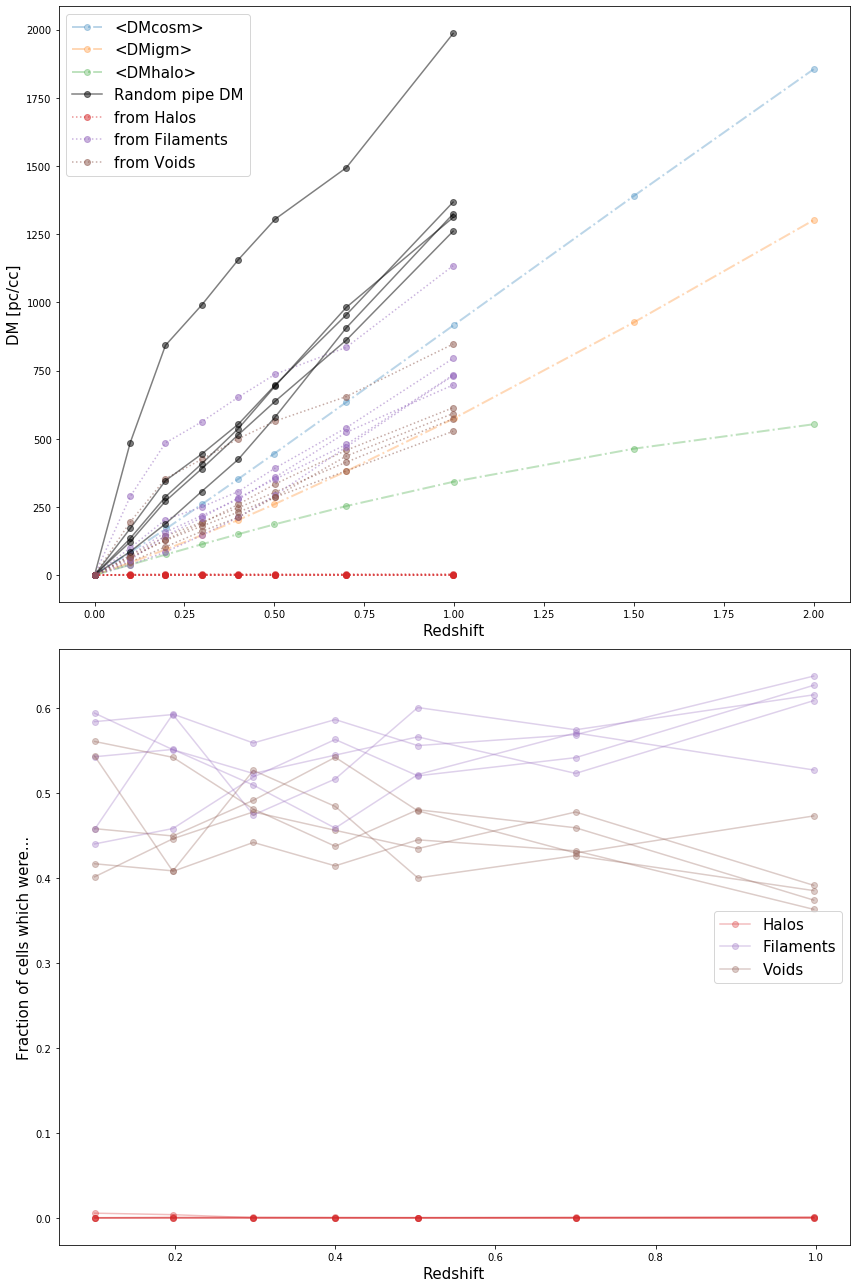

In [415]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

for i in range(5):
    if i==0:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5,label='Random pipe DM')
        ax.plot(snap_z_list,Hal_cDM_arr[:,i],marker='o',ls=':',color='C3',alpha=0.5,label='from Halos')
        ax.plot(snap_z_list,Fil_cDM_arr[:,i],marker='o',ls=':',color='C4',alpha=0.5,label='from Filaments')
        ax.plot(snap_z_list,Voi_cDM_arr[:,i],marker='o',ls=':',color='C5',alpha=0.5,label='from Voids')

    else:
        ax.plot(snap_z_list,cDM_arr[:,i],marker='o',color='k',alpha=0.5)
        ax.plot(snap_z_list,Hal_cDM_arr[:,i],marker='o',ls=':',color='C3',alpha=0.5)
        ax.plot(snap_z_list,Fil_cDM_arr[:,i],marker='o',ls=':',color='C4',alpha=0.5)
        ax.plot(snap_z_list,Voi_cDM_arr[:,i],marker='o',ls=':',color='C5',alpha=0.5)
plt.legend(fontsize=15)

        
ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)

for i in range(5):
    if i==0:
        ax2.plot(snap_z_list[1:],frac_Hal_arr[:,i][1:],marker='o',alpha=0.3,color='C3',label='Halos')
        ax2.plot(snap_z_list[1:],frac_Fil_arr[:,i][1:],marker='o',alpha=0.3,color='C4',label='Filaments')
        ax2.plot(snap_z_list[1:],frac_Voi_arr[:,i][1:],marker='o',alpha=0.3,color='C5',label='Voids')
    else:
        ax2.plot(snap_z_list[1:],frac_Hal_arr[:,i][1:],marker='o',alpha=0.3,color='C3')
        ax2.plot(snap_z_list[1:],frac_Fil_arr[:,i][1:],marker='o',alpha=0.3,color='C4')
        ax2.plot(snap_z_list[1:],frac_Voi_arr[:,i][1:],marker='o',alpha=0.3,color='C5')

plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Analysis.png'.format(sim_to_load),formaat='png')
plt.show()

## get statistics

In [416]:
#totals
mean_cDM_arr = np.mean(cDM_arr,axis=1) #mean
medi_cDM_arr = np.median(cDM_arr,axis=1) #median
stdv_cDM_arr = np.std(cDM_arr,axis=1) #standard deviation

#halos
mean_Hal_cDM_arr = np.mean(Hal_cDM_arr,axis=1) #mean
medi_Hal_cDM_arr = np.median(Hal_cDM_arr,axis=1) #median
stdv_Hal_cDM_arr = np.std(Hal_cDM_arr,axis=1) #standard deviation

mean_frac_Hal_arr = np.mean(frac_Hal_arr,axis=1) #mean
medi_frac_Hal_arr = np.median(frac_Hal_arr,axis=1) #median
stdv_frac_Hal_arr = np.std(frac_Hal_arr,axis=1) #standard deviation

#filaments
mean_Fil_cDM_arr = np.mean(Fil_cDM_arr,axis=1) #mean
medi_Fil_cDM_arr = np.median(Fil_cDM_arr,axis=1) #median
stdv_Fil_cDM_arr = np.std(Fil_cDM_arr,axis=1) #standard deviation

mean_frac_Fil_arr = np.mean(frac_Fil_arr,axis=1) #mean
medi_frac_Fil_arr = np.median(frac_Fil_arr,axis=1) #median
stdv_frac_Fil_arr = np.std(frac_Fil_arr,axis=1) #standard deviation

#voids
mean_Voi_cDM_arr = np.mean(Voi_cDM_arr,axis=1) #mean
medi_Voi_cDM_arr = np.median(Voi_cDM_arr,axis=1) #median
stdv_Voi_cDM_arr = np.std(Voi_cDM_arr,axis=1) #standard deviation

mean_frac_Voi_arr = np.mean(frac_Voi_arr,axis=1) #mean
medi_frac_Voi_arr = np.median(frac_Voi_arr,axis=1) #median
stdv_frac_Voi_arr = np.std(frac_Voi_arr,axis=1) #standard deviation

print('Mean cDM: ',mean_cDM_arr)
print('Median cDM: ',medi_cDM_arr)
print('Standard deviation of cDM: ',stdv_cDM_arr)

Mean cDM:  [   0.          134.71488191  273.5254406   420.46636427  572.32049411
  727.42638132 1022.72878415 1459.22361287] pc / cm3
Median cDM:  [   0.          121.80824559  251.83643904  392.94904547  541.28702395
  693.69416718  983.20451877 1413.52546039] pc / cm3
Standard deviation of cDM:  [  0.          59.76836075 105.84864196 134.37942986 158.08787659
 175.19458374 216.8494233  269.27577817] pc / cm3


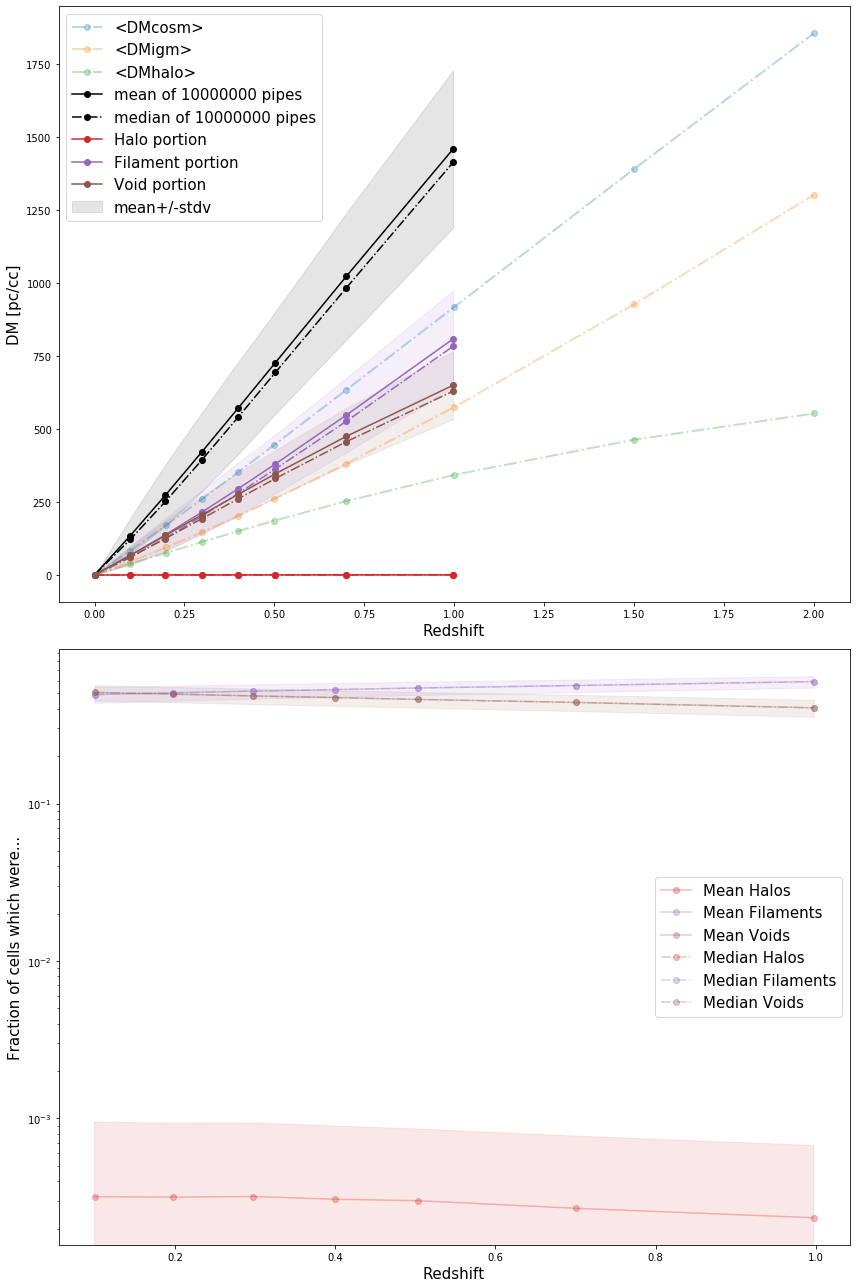

In [417]:
fig = plt.figure(figsize=(12,18))
ax = fig.add_subplot(211)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM [pc/cc]',fontsize=15)

ax.plot(theory_z_2,cosm_theory_2,marker='o',color='C0',ls='-.',lw=2,alpha=0.3,label='<DMcosm>')
ax.plot(theory_z_2,igm_theory_2,marker='o',color='C1',ls='-.',lw=2,alpha=0.3,label='<DMigm>')
ax.plot(theory_z_2,halo_theory_2,marker='o',color='C2',ls='-.',lw=2,alpha=0.3,label='<DMhalo>')

ax.plot(snap_z_list,mean_cDM_arr,marker='o',color='k',alpha=1,ls='-',label='mean of {0} pipes'.format(cDM_arr.shape[1]))
ax.plot(snap_z_list,medi_cDM_arr,marker='o',color='k',alpha=1,ls='-.',label='median of {0} pipes'.format(cDM_arr.shape[1]))
ax.fill_between(snap_z_list,mean_cDM_arr+stdv_cDM_arr,mean_cDM_arr-stdv_cDM_arr,alpha=0.1,color='k',label='mean+/-stdv')


ax.plot(snap_z_list,mean_Hal_cDM_arr,marker='o',color='C3',alpha=1,ls='-',label='Halo portion')
ax.plot(snap_z_list,medi_Hal_cDM_arr,marker='o',color='C3',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Hal_cDM_arr+stdv_Hal_cDM_arr,mean_Hal_cDM_arr-stdv_Hal_cDM_arr,alpha=0.1,color='C3')

ax.plot(snap_z_list,mean_Fil_cDM_arr,marker='o',color='C4',alpha=1,ls='-',label='Filament portion')
ax.plot(snap_z_list,medi_Fil_cDM_arr,marker='o',color='C4',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Fil_cDM_arr+stdv_Fil_cDM_arr,mean_Fil_cDM_arr-stdv_Fil_cDM_arr,alpha=0.1,color='C4')

ax.plot(snap_z_list,mean_Voi_cDM_arr,marker='o',color='C5',alpha=1,ls='-',label='Void portion')
ax.plot(snap_z_list,medi_Voi_cDM_arr,marker='o',color='C5',alpha=1,ls='-.')
ax.fill_between(snap_z_list,mean_Voi_cDM_arr+stdv_Voi_cDM_arr,mean_Voi_cDM_arr-stdv_Voi_cDM_arr,alpha=0.1,color='C5')


plt.legend(fontsize=15)


ax2 = fig.add_subplot(212)
ax2.set_xlabel('Redshift',fontsize=15)
ax2.set_ylabel('Fraction of cells which were...',fontsize=15)
ax2.set_yscale('log')

ax2.plot(snap_z_list[1:],mean_frac_Hal_arr[1:],marker='o',alpha=0.3,color='C3',label='Mean Halos')
ax2.plot(snap_z_list[1:],mean_frac_Fil_arr[1:],marker='o',alpha=0.3,color='C4',label='Mean Filaments')
ax2.plot(snap_z_list[1:],mean_frac_Voi_arr[1:],marker='o',alpha=0.3,color='C5',label='Mean Voids')

ax2.plot(snap_z_list[1:],medi_frac_Hal_arr[1:],ls='-.',marker='o',alpha=0.3,color='C3',label='Median Halos')
ax2.plot(snap_z_list[1:],medi_frac_Fil_arr[1:],ls='-.',marker='o',alpha=0.3,color='C4',label='Median Filaments')
ax2.plot(snap_z_list[1:],medi_frac_Voi_arr[1:],ls='-.',marker='o',alpha=0.3,color='C5',label='Median Voids')

ax2.fill_between(snap_z_list[1:],mean_frac_Hal_arr[1:]+stdv_frac_Hal_arr[1:],mean_frac_Hal_arr[1:]-stdv_frac_Hal_arr[1:],alpha=0.1,color='C3')
ax2.fill_between(snap_z_list[1:],mean_frac_Fil_arr[1:]+stdv_frac_Fil_arr[1:],mean_frac_Fil_arr[1:]-stdv_frac_Fil_arr[1:],alpha=0.1,color='C4')
ax2.fill_between(snap_z_list[1:],mean_frac_Voi_arr[1:]+stdv_frac_Voi_arr[1:],mean_frac_Voi_arr[1:]-stdv_frac_Voi_arr[1:],alpha=0.1,color='C5')


plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics.png'.format(sim_to_load),format='png')
plt.show()

# Plot cumulative DM fraction a bit like in the Aghanim presentation

[   0.          134.71488191  273.5254406   420.46636427  572.32049411
  727.42638132 1022.72878415 1459.22361287] pc / cm3


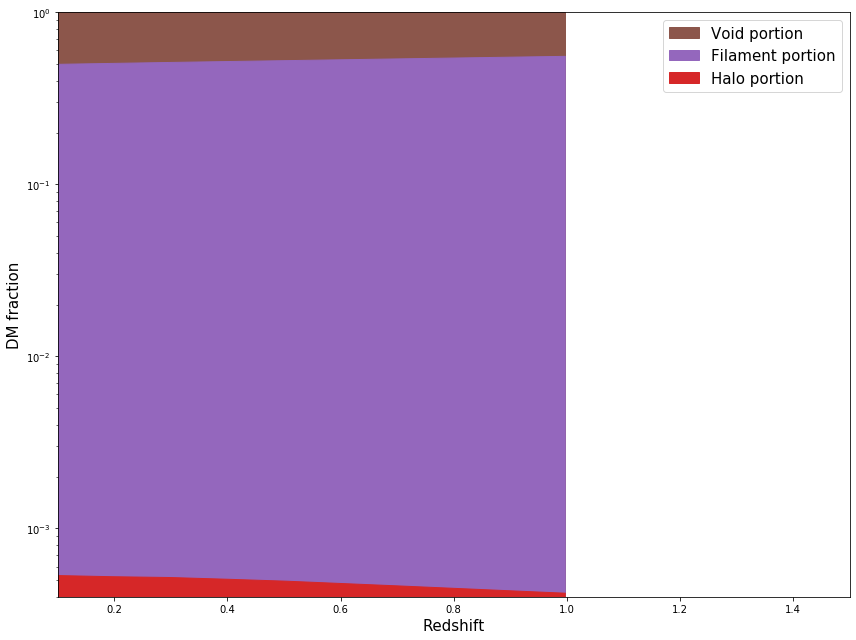

In [419]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('Redshift',fontsize=15)
ax.set_ylabel('DM fraction',fontsize=15)
ax.set_yscale('log')
ax.set_xlim([0.1,1.5])
ax.set_ylim([4e-4,1.])


ax.fill_between(snap_z_list,((mean_Voi_cDM_arr+mean_Fil_cDM_arr+mean_Hal_cDM_arr)/mean_cDM_arr[:]),color='C5',alpha=1,ls='-',label='Void portion')
ax.fill_between(snap_z_list,((mean_Fil_cDM_arr+mean_Hal_cDM_arr)/mean_cDM_arr[:]),color='C4',alpha=1,ls='-',label='Filament portion')
ax.fill_between(snap_z_list,mean_Hal_cDM_arr/mean_cDM_arr[:],color='C3',alpha=1,ls='-',label='Halo portion')


plt.legend(fontsize=15)

print(mean_Voi_cDM_arr+mean_Fil_cDM_arr+mean_Hal_cDM_arr)
plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Multi_LoS_Statistics_2.png'.format(sim_to_load),format='png')
plt.show()

# Histograms of results 

In [420]:
#method for histogramming over one axis from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy

def hist_1d(data,bins=np.linspace(0,5000,100)):
    """
    histograms data along one axis
    adapted from https://stackoverflow.com/questions/40018125/binning-of-data-along-one-axis-in-numpy
    
    INPUTS:
    
    data : [arr]  array of data to histogram
    """
    
    return np.histogram(data,bins=bins,density=True)[0]

######################
#do the histogramming#
######################

#total
#bin_edges = np.linspace(0,5000,500)
bin_edges = np.logspace(0,3.5,num=100)

counts = np.apply_along_axis(hist_1d, 1, cDM_arr.value,bin_edges)

Hal_counts = np.apply_along_axis(hist_1d, 1, Hal_cDM_arr.value,bin_edges)
Fil_counts = np.apply_along_axis(hist_1d, 1, Fil_cDM_arr.value,bin_edges)
Voi_counts = np.apply_along_axis(hist_1d, 1, Voi_cDM_arr.value,bin_edges)


/mpcdf/soft/SLE_15/packages/x86_64/anaconda/3/2020.02/lib/python3.7/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [421]:
print(counts.shape)
print(bin_edges.shape)

(8, 99)
(100,)


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


6 0.7001063537185233
7 0.9972942257819404
1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635
5 0.5030475232448832


No handles with labels found to put in legend.
No handles with labels found to put in legend.


6 0.7001063537185233
7 0.9972942257819404


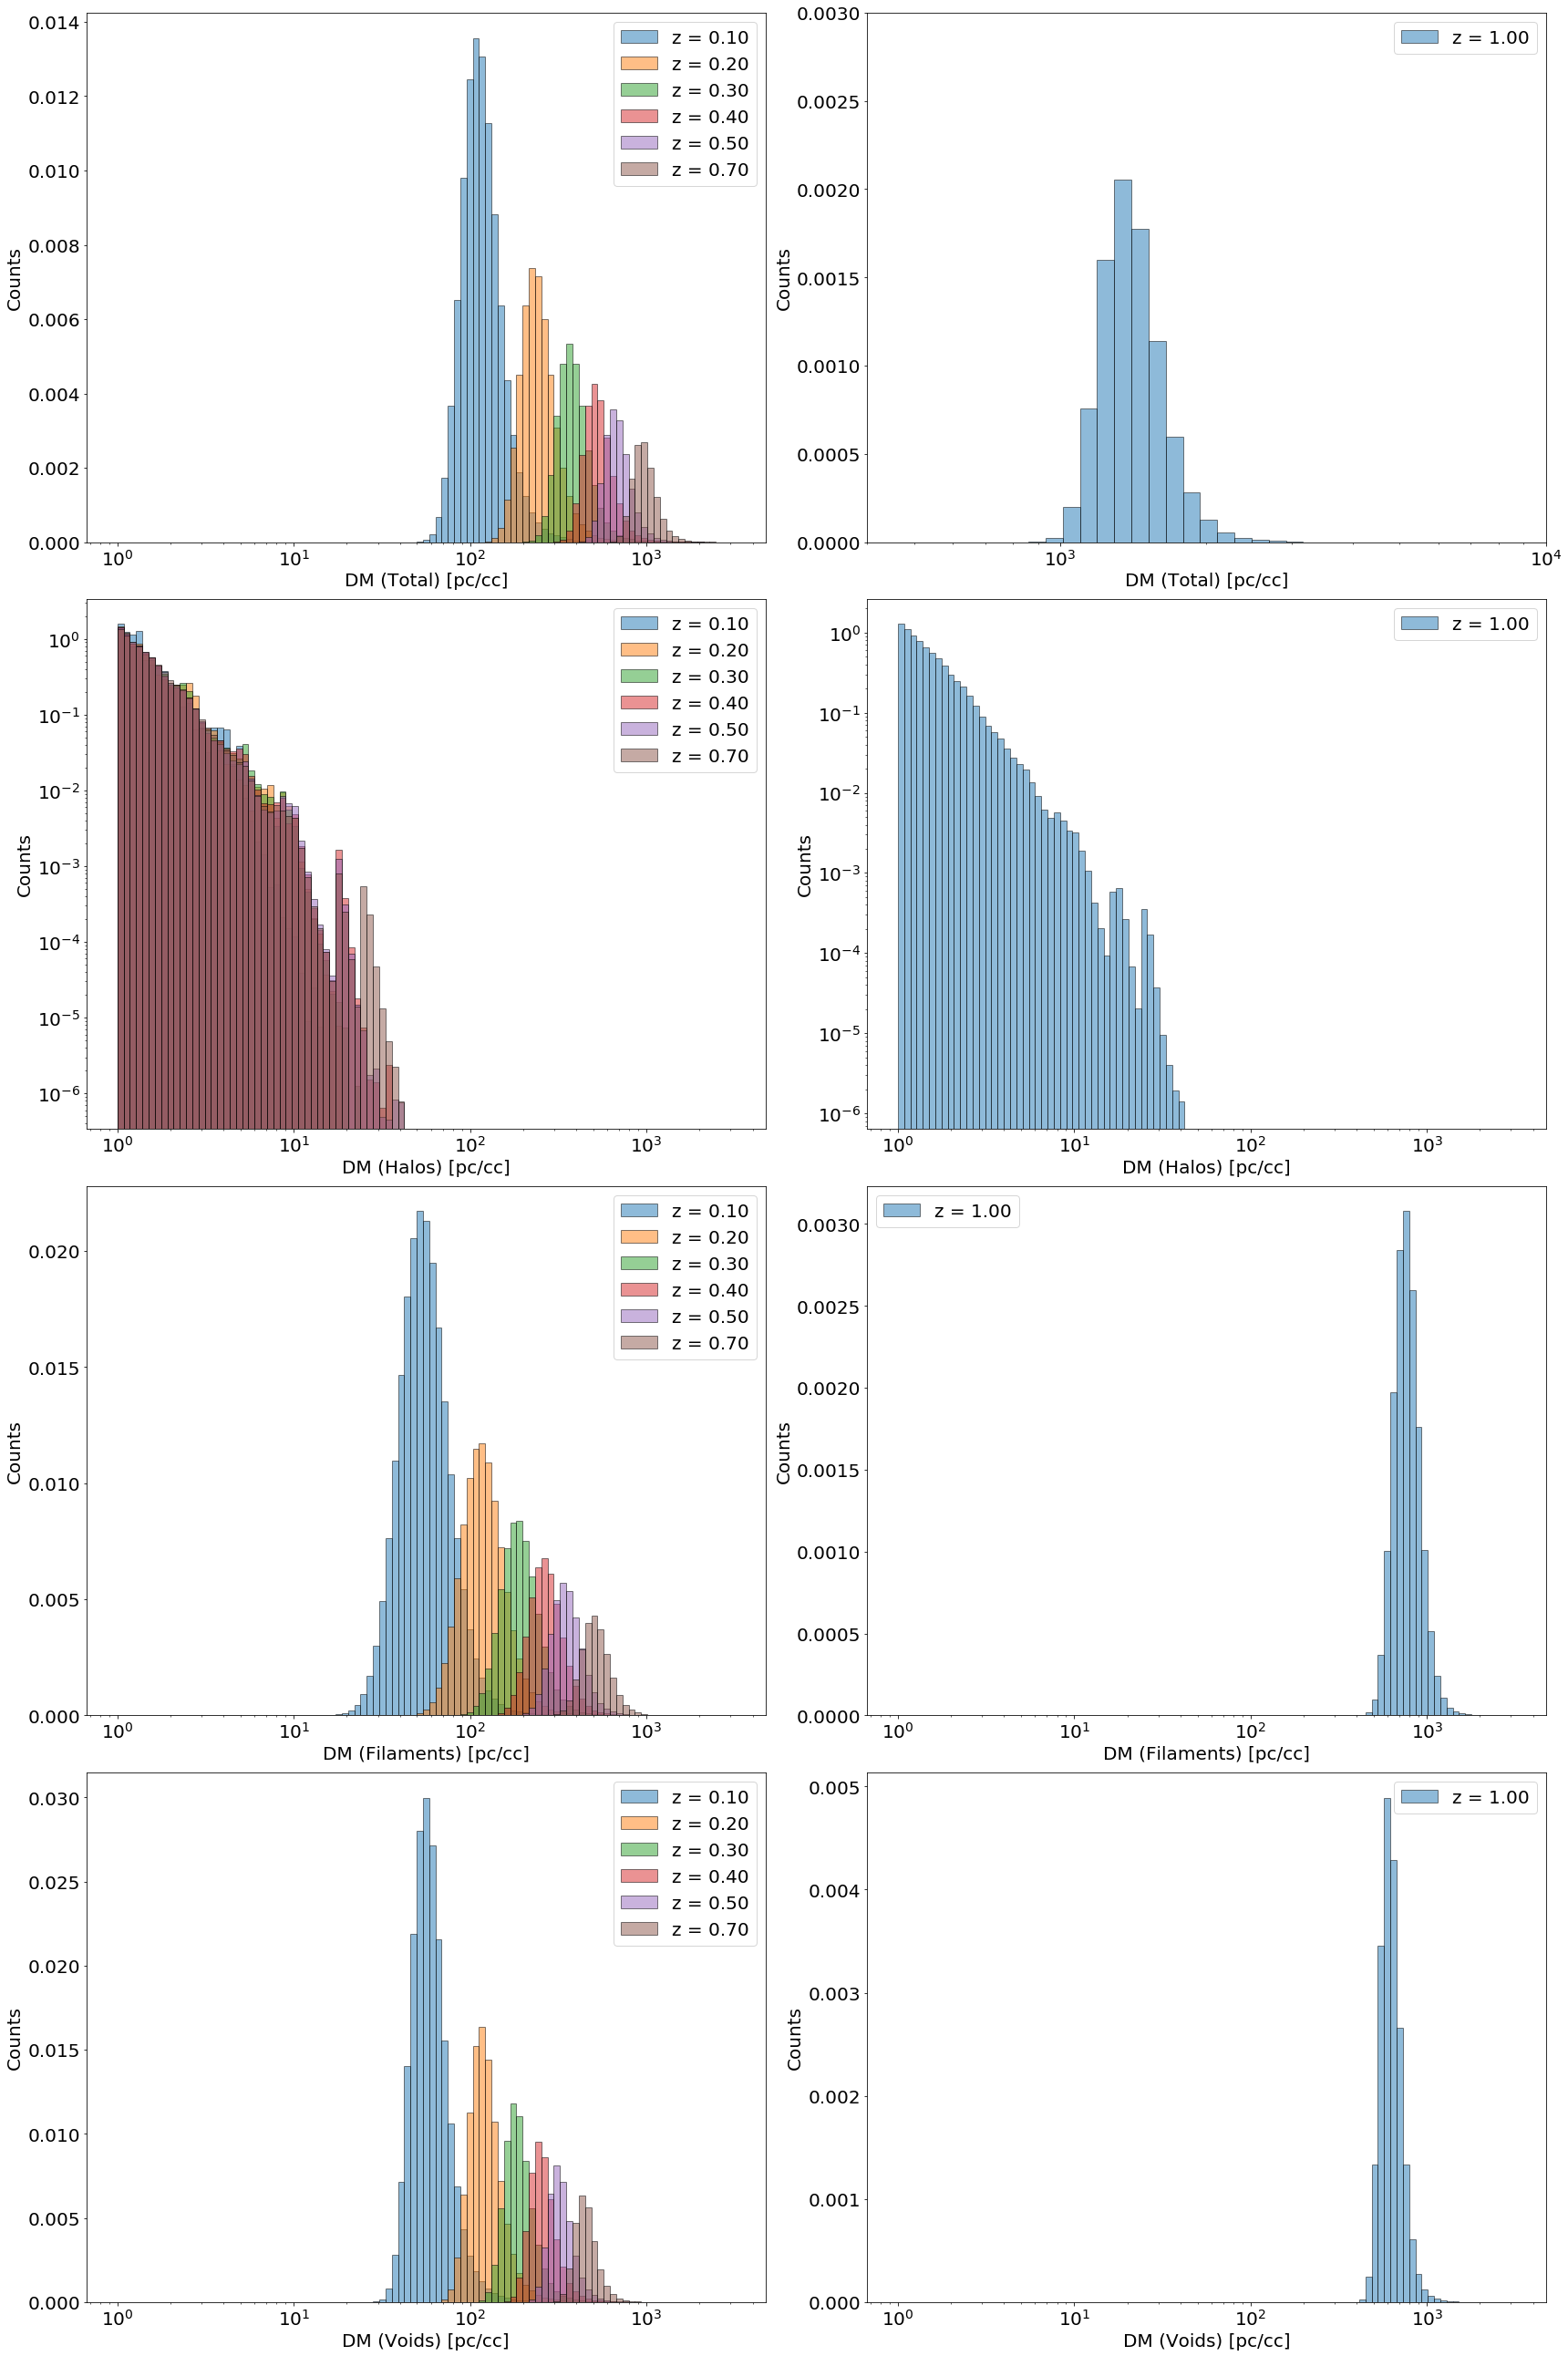

In [422]:
#histogram method from: https://stackoverflow.com/questions/64616617/matplotlib-plot-histogram-given-pre-computed-counts-and-bins

fig = plt.figure(figsize=(24,36))
ax1 = fig.add_subplot(421)
ax1.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(422)
ax2.set_xlabel('DM (Total) [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)
    
ax3 = fig.add_subplot(423)
ax3.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax3.set_ylabel('Counts',fontsize=20)
ax3.set_xscale('log')
ax3.set_yscale('log')
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

ax4 = fig.add_subplot(424)
ax4.set_xlabel('DM (Halos) [pc/cc]',fontsize=20)
ax4.set_ylabel('Counts',fontsize=20)
ax4.set_xscale('log')
ax4.set_yscale('log')
#ax4.set_ylim([0,0.003])
#ax4.set_xlim([4e2,1e4])
ax4.tick_params(axis='x', labelsize=20)
ax4.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax3.bar(x=bin_edges[:-1], height=Hal_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax4.bar(x=bin_edges[:-1], height=Hal_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax3.legend(fontsize=20)
    ax4.legend(fontsize=20)
    
ax5 = fig.add_subplot(425)
ax5.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax5.set_ylabel('Counts',fontsize=20)
ax5.set_xscale('log')
#ax5.set_yscale('log')
ax5.tick_params(axis='x', labelsize=20)
ax5.tick_params(axis='y', labelsize=20)

ax6 = fig.add_subplot(426)
ax6.set_xlabel('DM (Filaments) [pc/cc]',fontsize=20)
ax6.set_ylabel('Counts',fontsize=20)
ax6.set_xscale('log')
#ax6.set_yscale('log')
#ax6.set_ylim([0,0.003])
#ax6.set_xlim([4e2,1e4])
ax6.tick_params(axis='x', labelsize=20)
ax6.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax5.bar(x=bin_edges[:-1], height=Fil_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax6.bar(x=bin_edges[:-1], height=Fil_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax5.legend(fontsize=20)
    ax6.legend(fontsize=20)

ax7 = fig.add_subplot(427)
ax7.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax7.set_ylabel('Counts',fontsize=20)
ax7.set_xscale('log')
#ax7.set_yscale('log')
ax7.tick_params(axis='x', labelsize=20)
ax7.tick_params(axis='y', labelsize=20)

ax8 = fig.add_subplot(428)
ax8.set_xlabel('DM (Voids) [pc/cc]',fontsize=20)
ax8.set_ylabel('Counts',fontsize=20)
ax8.set_xscale('log')
#ax8.set_yscale('log')
#ax8.set_ylim([0,0.003])
#ax8.set_xlim([4e2,1e4])
ax8.tick_params(axis='x', labelsize=20)
ax8.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i<7:
        print(i,snap_z_list[i])
        ax7.bar(x=bin_edges[:-1], height=Voi_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
    elif i>=7:
        print(i,snap_z_list[i])
        ax8.bar(x=bin_edges[:-1], height=Voi_counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',label='z = {0:.2f}'.format(snap_z_list[i]))
        #plt.legend(fontsize=15)
    ax7.legend(fontsize=20)
    ax8.legend(fontsize=20)

plt.tight_layout()
plt.savefig('LSS_Analysis_Hists_{0}.png'.format(sim_to_load),format='png')
plt.show()

# Plot the fits from Zhang+20

In [425]:
#print(snap_z_list[1:])
#print(np.linspace(0.01,10000))
#print(mean_cDM_arr)
print(len(cosm_theory_2))
print(np.array(theory_z_2)[1:-1])

xarr = np.linspace(0,10000,10000)

#I was unsure what <DMIGM> should go into the data so I did two tests below:
#Test 1: <DMIGM> is the mean of my DM IGM values
Delta_mydata = np.array([xarr/i for i in mean_cDM_arr[1:]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the mean of my data
#Test 2: <DMIGM> is the value from the macquart relation (i.e. <DMcosm)
Delta_macq = np.array([xarr/i for i in np.array(cosm_theory_2)[1:-1]]) #DMIGM/<DMIGM> (only for z=0.1 and above) using the macquart relation

A = np.array([0.04721,0.005693,0.003584,0.002876,0.002423,0.001880,0.001456,0.001098]) #from Zhang+20 table 1
alpha=3
beta=3
C0 = np.array([-13.17,-1.008,0.596,1.010,1.127,1.170,1.189,1.163]) #from Zhang+20 table 1
sigmaDM = np.array([2.554,1.118,0.7043,0.5158,0.4306,0.3595,0.3044,0.2609]) #from Zhang+20 table 1


#create the P curves for each Delta
P_mydata=(A[:,None]*(Delta_mydata)**(-1*beta))*np.exp(-1*((((Delta_mydata**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))
P_macq=(A[:,None]*(Delta_macq)**(-1*beta))*np.exp(-1*((((Delta_macq**(-1*alpha))-C0[:,None])**2)/(2*alpha**2*sigmaDM[:,None]**2)))

#plot to test
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(111)
ax.set_xlabel('DM [pc/cc]',fontsize=15)
ax.set_ylabel('P($\Delta$)',fontsize=15)
ax.set_xscale('log')
for i in range(P_mydata.shape[0]):
    ax.plot(xarr,P_mydata[i],color='C{0}'.format(i),label='P@z={0:.2f} with <my DMs>'.format(snap_z_list[1:][i]))
    ax.plot(xarr,P_macq[i],ls='--',color='C{0}'.format(i),label='P@z={0:.2f} with <DMcosm>'.format(snap_z_list[1:][i]))


plt.legend(fontsize=15)
plt.tight_layout()
plt.savefig('{0}_Zhang_Fits.png'.format(sim_to_load),format='png')
plt.show()
#print(Delta)

10
[0.1 0.2 0.3 0.4 0.5 0.7 1.  1.5]


/raven/u/cwalker/virtual_environments/yt-env/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in power


ValueError: operands could not be broadcast together with shapes (8,1) (7,10000) 

Result: Unsure which mean to use. This should be discussed with Laura as our values are actually different to Zhangs, and so these curves might also differ...

# Overplot the fits on the histograms

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


1 0.09940180263022191
2 0.19728418237600986
3 0.2977176845174465
4 0.3999269646135635


No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


5 0.5030475232448832
6 0.7001063537185233
7 0.9972942257819404


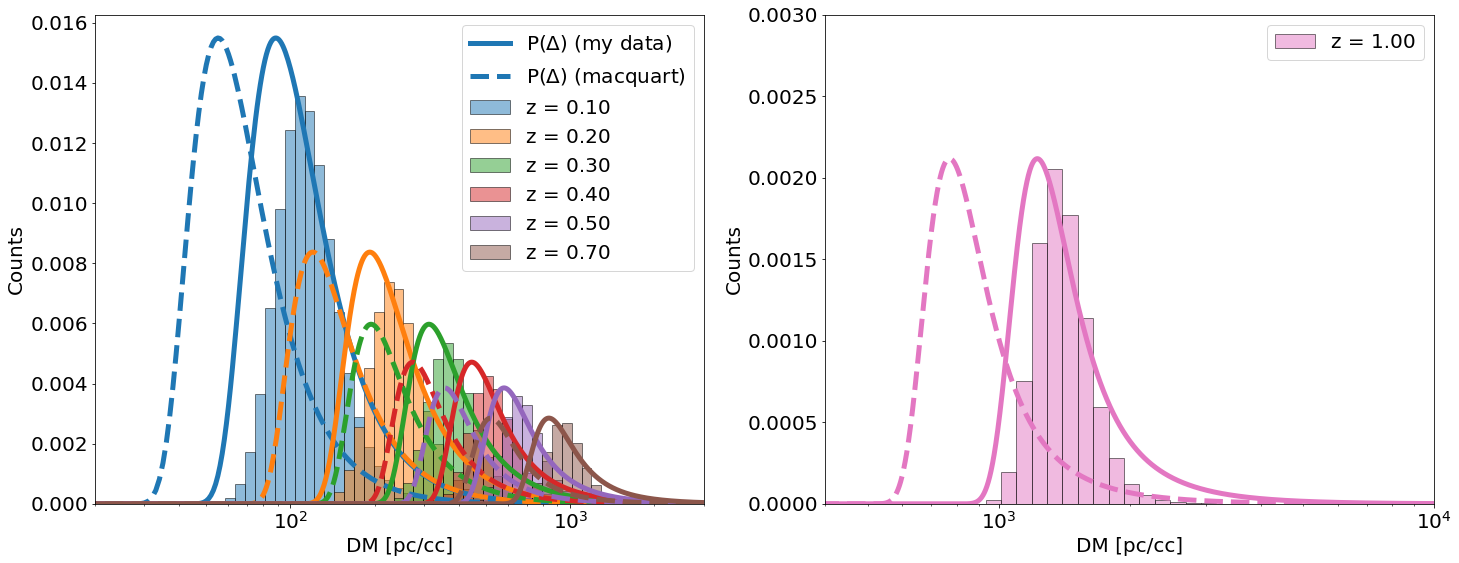

In [426]:
fig = plt.figure(figsize=(24,9))
ax1 = fig.add_subplot(121)
ax1.set_xlabel('DM [pc/cc]',fontsize=20)
ax1.set_ylabel('Counts',fontsize=20)
ax1.set_xscale('log')
ax1.set_xlim([2e1,3e3])
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)

ax2 = fig.add_subplot(122)
ax2.set_xlabel('DM [pc/cc]',fontsize=20)
ax2.set_ylabel('Counts',fontsize=20)
ax2.set_xscale('log')
ax2.set_ylim([0,0.003])
ax2.set_xlim([4e2,1e4])
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)


for i in range(len(snap_z_list)):
    #exclude z=0 because the DM is 0
    if i==0:
        pass
    elif i==1:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (my data)')
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5,label='P($\Delta$) (macquart)')
        
    elif i<7:
        print(i,snap_z_list[i])
        ax1.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax1.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5)
        ax1.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        
    elif i>=7:
        print(i,snap_z_list[i])
        ax2.bar(x=bin_edges[:-1], height=counts[i], width=np.diff(bin_edges), align='edge', alpha=0.5, ec='black',color='C{0}'.format(i-1),label='z = {0:.2f}'.format(snap_z_list[i]))
        ax2.plot(xarr,P_mydata[i-1],color='C{0}'.format(i-1),lw=5)
        ax2.plot(xarr,P_macq[i-1],ls='--',color='C{0}'.format(i-1),lw=5)

        #plt.legend(fontsize=15)
    ax1.legend(fontsize=20)
    ax2.legend(fontsize=20)

plt.tight_layout
plt.savefig('{0}_Zhang_Fit_Data_Comparisons.png'.format(sim_to_load),format='png')
plt.show()
